Copyright (c) Meta Platforms, Inc. and affiliates.
This software may be used and distributed according to the terms of the Llama 2 Community License Agreement.

<a href="https://colab.research.google.com/github/meta-llama/llama-recipes/blob/main/recipes/quickstart/finetuning/quickstart_peft_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PEFT Finetuning Quick Start Notebook

This notebook shows how to train a Meta Llama 3 model on a single GPU (e.g. A10 with 24GB) using int8 quantization and LoRA finetuning.

**_Note:_** To run this notebook on a machine with less than 24GB VRAM (e.g. T4 with 16GB) the context length of the training dataset needs to be adapted.
We do this based on the available VRAM during execution.
If you run into OOM issues try to further lower the value of train_config.context_length.

### Step 0: Install pre-requirements and convert checkpoint

We need to have llama-recipes and its dependencies installed for this notebook. Additionally, we need to log in with the huggingface_cli and make sure that the account is able to to access the Meta Llama weights.

In [1]:
# conda create -n ladlm_v1 python=3.11
# !conda install -y pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia

In [2]:
# uncomment if running from Colab T4
# ! pip install llama-recipes ipywidgets

In [3]:
# !pip install huggingface_hub

In [4]:
from huggingface_hub import login
# login() 

### Step 1: Load the model

Setup training configuration and load the model and tokenizer.

In [ ]:
import torch
from transformers import MllamaForConditionalGeneration, AutoTokenizer, AutoProcessor
from llama_recipes.configs import train_config as TRAIN_CONFIG

train_config = TRAIN_CONFIG()
train_config.model_name = "meta-llama/Llama-3.2-11B-Vision-Instruct"
train_config.num_epochs = 1
train_config.run_validation = False
train_config.gradient_accumulation_steps = 4
train_config.batch_size_training = 1
train_config.lr = 3e-4
train_config.use_fast_kernels = True
train_config.use_fp16 = True
train_config.context_length = 256 if torch.cuda.get_device_properties(0).total_memory < 16e9 else 1024 # T4 16GB or A10 24GB
train_config.batching_strategy = "packing"
train_config.output_dir = "ladlm_v1"
train_config.use_peft = True

from transformers import BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)


model = MllamaForConditionalGeneration.from_pretrained(
            train_config.model_name,
            quantization_config=bnb_config,
            device_map="auto",
            torch_dtype=torch.float16,
        )
processor = AutoProcessor.from_pretrained(train_config.model_name)

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

### Step 2: Check base model

Run the base model on an example input:

We can see that the base model only repeats the conversation.

### Step 3: Load the preprocessed dataset

We load and preprocess the samsum dataset which consists of curated pairs of dialogs and their summarization:

In [6]:
import ladlm_dataset

In [7]:
import ladlm_dataset
from torch.utils.data import DataLoader

# Train/Test 데이터셋 로드
train_dataset = ladlm_dataset.get_custom_dataset(
    dataset_config=None,
    processor=processor,
    split="train",
    split_ratio=0.9
)

eval_dataset = ladlm_dataset.get_custom_dataset(
    dataset_config=None,
    processor=processor,
    split="test",
    split_ratio=0.9
)

# Data Collator 생성
data_collator = ladlm_dataset.get_data_collator(processor)

# DataLoader 생성
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=train_config.batch_size_training, 
    collate_fn=data_collator, 
    shuffle=True
)

eval_dataloader = DataLoader(
    eval_dataset, 
    batch_size=train_config.batch_size_training, 
    collate_fn=data_collator, 
    shuffle=False
)

print(f"Train DataLoader and Eval DataLoader ready!")



Train DataLoader and Eval DataLoader ready!


In [8]:
# !pip install librosa

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. plot parameters: {'figsize': ['5.12', '5.12'], 'dpi': 100, 'file_format': 'png'}.
 Explanation about spectrogram:<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The image is a spectrogram, which is a visual representation of the frequency content of a signal over time. The spectrogram is created using the Short


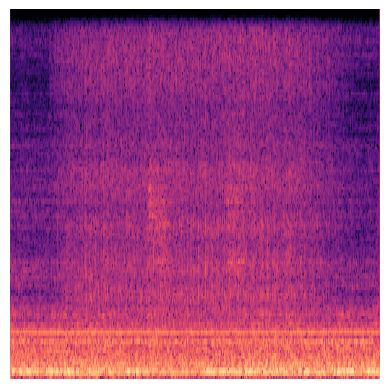

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# 테스트 데이터셋의 첫 번째 샘플 가져오기
sample = train_dataset[0]

# 첫 번째 샘플의 이미지와 텍스트 추출
file_name = sample['file_name']

linear_spectrogram_with_axes_image = sample['linear_spectrogram_with_axes']['image'].convert("RGB")
linear_spectrogram_no_axes_image = sample['linear_spectrogram_no_axes']['image'].convert("RGB")

librosa_parameters = sample['linear_spectrogram_no_axes']['librosa_parameters']
plot_parameters = sample['linear_spectrogram_no_axes']['plot_parameters']

domain = sample['domain']              
type = sample['type']                  
machineType = sample['machineType']    
explanation_about_spectrogram = sample['explanation_about_spectrogram']


messages = [
    [
        {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text",
                "text": f"This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. "
                        f"The parameters used to extract this image are as follows: {librosa_parameters}. "
                        f"Plot parameters: {plot_parameters}.\nExplanation about spectrogram:"}
        ]},
    ]
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    linear_spectrogram_no_axes_image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt"
).to(model.device)

# # 입력을 모델이 있는 디바이스로 이동
# inputs = {key: value.to(model.device) for key, value in inputs.items()}

# 인퍼런스 수행
with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=30)

print(processor.decode(output[0]))

# 이미지 표시 (선택 사항)
plt.imshow(linear_spectrogram_no_axes_image)
plt.axis('off')
plt.show()

In [10]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'aspect_ratio_ids', 'aspect_ratio_mask', 'cross_attention_mask'])

In [11]:
model

MllamaForConditionalGeneration(
  (vision_model): MllamaVisionModel(
    (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), padding=valid, bias=False)
    (gated_positional_embedding): MllamaPrecomputedPositionEmbedding(
      (tile_embedding): Embedding(9, 8197120)
    )
    (pre_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
      (embedding): Embedding(9, 5120)
    )
    (post_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
      (embedding): Embedding(9, 5120)
    )
    (layernorm_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (layernorm_post): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (transformer): MllamaVisionEncoder(
      (layers): ModuleList(
        (0-31): 32 x MllamaVisionEncoderLayer(
          (self_attn): MllamaVisionSdpaAttention(
            (q_proj): Linear4bit(in_features=1280, out_features=1280, bias=False)
            (k_proj): Linear4bit(in_features=1280, out_features

### Step 4: Prepare model for PEFT

Let's prepare the model for Parameter Efficient Fine Tuning (PEFT):

In [12]:
from peft import get_peft_model, prepare_model_for_kbit_training, LoraConfig
from dataclasses import asdict
from llama_recipes.configs import lora_config as LORA_CONFIG

lora_config = LORA_CONFIG()
lora_config.r = 8
lora_config.lora_alpha = 32
lora_dropout: float=0.01

peft_config = LoraConfig(**asdict(lora_config))

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

### Step 5: Fine tune the model

Here, we fine tune the model for a single epoch.

In [13]:
import torch.optim as optim
from llama_recipes.utils.train_utils import train
from torch.optim.lr_scheduler import StepLR

model.train()

optimizer = optim.AdamW(
            model.parameters(),
            lr=train_config.lr,
            weight_decay=train_config.weight_decay,
        )
scheduler = StepLR(optimizer, step_size=1, gamma=train_config.gamma)

# Start the training process
results = train(
    model,
    train_dataloader,
    eval_dataloader,
    processor, # tokenizor 대채
    optimizer,
    scheduler,
    train_config.gradient_accumulation_steps,
    train_config,
    None,
    None,
    None,
    wandb_run=None,
)

/home/uturtle/anaconda3/envs/llama_recipe_vision/lib/python3.11/site-packages/llama_recipes/model_checkpointing/checkpoint_handler.py:17: DeprecationWarning: `torch.distributed._shard.checkpoint` will be deprecated, use `torch.distributed.checkpoint` instead
  from torch.distributed._shard.checkpoint import (
/home/uturtle/anaconda3/envs/llama_recipe_vision/lib/python3.11/site-packages/llama_recipes/utils/train_utils.py:92: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/uturtle/anaconda3/envs/llama_recipe_vision/lib/python3.11/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Starting epoch 0/1
train_config.max_train_step: 0


Training Epoch: 1:   0%|          | 0/67 [00:00<?, ?it/s]/home/uturtle/anaconda3/envs/llama_recipe_vision/lib/python3.11/site-packages/llama_recipes/utils/train_utils.py:152: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/uturtle/anaconda3/envs/llama_recipe_vision/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/uturtle/anaconda3/envs/llama_recipe_vision/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradien

Max CUDA memory allocated was 11 GB
Max CUDA memory reserved was 11 GB
Peak active CUDA memory was 11 GB
CUDA Malloc retries : 1
CPU Total Peak Memory consumed during the train (max): 4 GB
Epoch 1: train_perplexity=1.4909, train_epoch_loss=0.3994, epoch time 301.57906554300007s


### Step 6:
Save model checkpoint

In [14]:
model.save_pretrained(train_config.output_dir)

### Step 7:
Try the fine tuned model on the same example again to see the learning progress:

In [15]:
import torch
from PIL import Image

# 모델을 평가 모드로 전환
model.eval()

# 테스트 데이터셋의 첫 번째 샘플 가져오기
sample = eval_dataset[1]


<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. Plot parameters: {'figsize': ['5.12', '5.12'], 'dpi': 100, 'file_format': 'png'}.
Explanation about spectrogram:<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy is present in the low-frequency range (0 kHz - 1 kHz). A region of weak intensity is observed around 6 kHz. Additionally


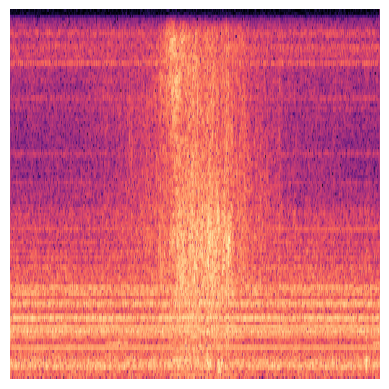

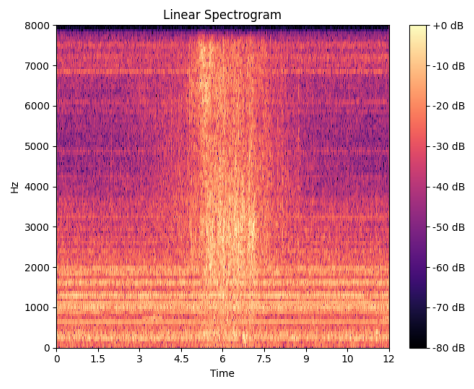

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# 첫 번째 샘플의 이미지와 텍스트 추출
file_name = sample['file_name']

linear_spectrogram_with_axes_image = sample['linear_spectrogram_with_axes']['image'].convert("RGB")
linear_spectrogram_no_axes_image = sample['linear_spectrogram_no_axes']['image'].convert("RGB")

librosa_parameters = sample['linear_spectrogram_no_axes']['librosa_parameters']
plot_parameters = sample['linear_spectrogram_no_axes']['plot_parameters']

domain = sample['domain']              
type = sample['type']                  
machineType = sample['machineType']    
explanation_about_spectrogram = sample['explanation_about_spectrogram']


messages = [
    [
        {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text",
                "text": f"This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. "
                        f"The parameters used to extract this image are as follows: {librosa_parameters}. "
                        f"Plot parameters: {plot_parameters}.\nExplanation about spectrogram:"}
        ]},
    ]
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    linear_spectrogram_no_axes_image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt"
).to(model.device)

# # 입력을 모델이 있는 디바이스로 이동
# inputs = {key: value.to(model.device) for key, value in inputs.items()}

# 인퍼런스 수행
with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=512)

print(processor.decode(output[0]))

# 이미지 표시 (선택 사항)
plt.imshow(linear_spectrogram_no_axes_image)
plt.axis('off')
plt.show()

plt.imshow(linear_spectrogram_with_axes_image)
plt.axis('off')
plt.show()